# Sound Classification

In the below notebook....

In [1]:
#import relevant packages
import pandas as pd
import numpy as np
from scipy import stats
import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,RocCurveDisplay
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import itertools
from collections import Counter
import re

from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, Flatten
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

import librosa
import librosa.display
from librosa import display

from PIL import Image
import os

In [2]:
#set a seed to use for random_state inputs for reproducability
SEED = 42

## Import Data

Please refer to the 'Audio_Pull' notebook to see how dataset was compiled from the public AudioSet dataset 
and how audio clips were downloaded
Please refer to the 'Spectrogram_Build' notebook to see how spectrograms were created
Please refer to 'Feature_Extraction' notebook to see how features were extracted from audio files.

#### 1. Spectrogram Images

Spectrogram images were created and saved down in the 'Spectrogram_Build' Notebook. Here, I import these images and classification labels.

In [3]:
#In downloading audio and creating spectrograms, some files resulted in an empty audio file and blank, white spetrogram
#This function is designed to filter out any empyty/blank data points
def is_blank_image(image, threshold=0.99):
    # Convert the image to a NumPy array
    image_array = np.array(image)
    # Calculate the mean pixel value
    mean_pixel_value = np.mean(image_array)
    # Check if the mean pixel value is below the threshold
    return mean_pixel_value > threshold



In [4]:
#Import images
image_folder = 'specs_sounds_128'
image_files = [file for file in os.listdir(image_folder) if file.lower().endswith(('.png'))]


labels = []
images = []

for file in image_files:
    image = Image.open(os.path.join(image_folder, file)).resize((128, 128))

    # Remove alpha color channel. this represents transparency and is not useful here.
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image = np.array(image) / 255
    
    # Check if the image is mostly blank and skip it if it is not then add to images
    if not is_blank_image(image):
        images.append(image)
        # Extract class label from the file name and add to labels
        label_label = file.split('_')[0]
        labels.append(label_label)

In [5]:
#check shape of sample image
np.shape(images[5])

(128, 128, 3)

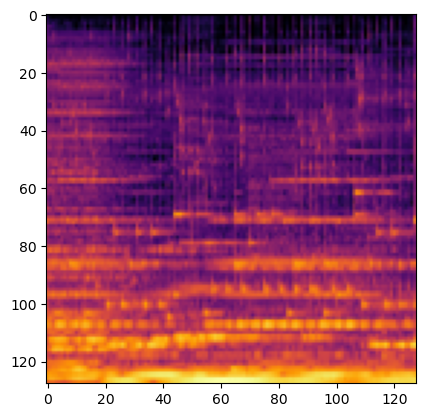

In [6]:
plt.imshow(images[52])

#### 2. Spectrogram Arrays

In addition to using images of the spectrograms to tune a image classification model, we're also going to use the spectrogram arrays, which are two dimensional to tune a cnn classification model. See below.

#Define functions to create mel spectrogram and add spectrogram arrays and classification labels to a list.

def create_mel_spectrogram(audio_file, n_mels=128, max_length=128):
    y, sr = librosa.load(audio_file)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Resize spectrogram to a fixed shape
    if mel_spectrogram.shape[1] < max_length:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_length - mel_spectrogram.shape[1])), mode='constant')
    elif mel_spectrogram.shape[1] > max_length:
        mel_spectrogram = mel_spectrogram[:, :max_length]

    return mel_spectrogram

def create_mel_spectrogram_dataset(audio_dir, n_mels=128, max_length=128):
    mel_spectrogram_list = []
    labels = []

    for file in os.listdir(audio_dir):
        if file.endswith(".wav"):  
            audio_file = os.path.join(audio_dir, file)
            mel_spectrogram = create_mel_spectrogram(audio_file, n_mels, max_length)
            mel_spectrogram_list.append(mel_spectrogram)

            # Extract labels from the file name
            label = file.split("_")[0]  
            labels.append(label)

    # Convert the lists of spectrogram arrays and labels to NumPy arrays
    mel_spectrogram_array = np.array(mel_spectrogram_list)
    labels_array = np.array(labels)

    return mel_spectrogram_array, labels_array

#execute functions on audio files saved in audio folder
X_spec_array, y_spec_array = create_mel_spectrogram_dataset('audio', n_mels=128)

#check shape
X_spec_array[100].shape

#### 2. Features

In addition to spectrograms, I extracted audio features from the .wav audio files. This code can be found in the 'Feature_Extraction' notebook. These numerical features are used below in various models including Random Forests, Logistic Regressions, and XG Boosted Ensemble models.

In [45]:
#import csv
features1 = pd.read_csv('features/sound_features.csv')

In [46]:
#view subset
features1.head()

,file_name,global_mean_chroma_stft,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,...,mfcc_8,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis
0,Speech_FT9BbKuz-vU.wav,0.301010,0.259437,0.293284,0.362778,0.340532,0.335875,0.346284,0.372173,0.331058,...,-7.710987,-3.804535,-1.328928,95.703125,129.199219,0.060157,0.047779,0.076274,2.264745,4.708135
1,Natural Sounds_pidEgqIBBns.wav,0.644790,0.684092,0.633538,0.638525,0.619494,0.586949,0.592642,0.594508,0.624069,...,-7.500875,-21.965170,12.280746,184.570312,123.046875,0.118936,0.095518,0.120399,1.033927,0.074668
2,Music_DHKXX1PUjdI.wav,0.325412,0.349722,0.245324,0.375099,0.303990,0.497178,0.448995,0.296847,0.416099,...,4.713310,-15.556738,2.608249,129.199219,129.199219,0.252015,0.204956,0.253555,0.822353,-0.287832
3,Animal_5R5te67I7Xg.wav,0.582531,0.527832,0.530989,0.536541,0.560560,0.594938,0.614481,0.596575,0.616836,...,9.674698,-8.673678,12.313059,135.999178,123.046875,0.012570,0.010128,0.013004,1.849239,1.694886
4,Music_JrUv5Y3WfZE.wav,0.503122,0.541557,0.505742,0.556515,0.458776,0.511832,0.452019,0.336280,0.382063,...,11.218300,1.920732,5.678011,143.554688,143.554688,0.345786,0.290247,0.353646,0.604745,-0.581886


In [47]:
#view stats
features1.describe()

,global_mean_chroma_stft,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,...,mfcc_8,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis
count,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,...,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,10985.000000,10980.000000,10980.000000
mean,0.462460,0.465006,0.455364,0.462187,0.454738,0.459592,0.454596,0.453966,0.466236,0.465831,...,1.901047,-4.815976,1.699779,124.274781,124.473928,0.108991,0.087449,0.121399,2.725560,20.062029
std,0.120518,0.154508,0.154295,0.155477,0.155313,0.152591,0.155418,0.151676,0.152940,0.154096,...,10.703322,10.517618,8.406562,30.281508,15.731961,0.102484,0.086666,0.105373,3.271913,155.444295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-46.331590,-59.447280,-42.198180,0.000000,37.999770,0.000100,0.000000,0.000000,-2.846342,-1.920252
25%,0.373298,0.357749,0.347132,0.354887,0.343966,0.352070,0.344813,0.347206,0.360868,0.357528,...,-4.301529,-11.168775,-3.160940,103.359375,117.453835,0.033556,0.025662,0.044084,1.267941,0.625757
50%,0.463783,0.467917,0.455387,0.460637,0.451767,0.458181,0.453113,0.454914,0.468414,0.470323,...,2.415569,-4.936186,2.005683,123.046875,123.046875,0.080438,0.062985,0.095508,1.921983,2.796955
75%,0.557232,0.577817,0.570402,0.576598,0.569816,0.572268,0.568696,0.565145,0.578238,0.578130,...,8.671467,1.008786,6.858452,143.554688,129.199219,0.154279,0.123013,0.168968,3.072150,9.170454
max,0.786966,0.999620,0.977630,1.000000,0.986985,1.000000,1.000000,0.985916,0.979609,1.000000,...,54.896946,45.179947,38.285446,287.109375,287.109375,0.914878,0.899041,0.916322,84.544132,9215.784088


In [48]:
#Extract class labels from the audio file names and create label column
def extract_label(filename):
    return filename.split('_')[0]

features1['label'] = features1['file_name'].apply(extract_label)

In [49]:
features1.head()

,file_name,global_mean_chroma_stft,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,...,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis,label
0,Speech_FT9BbKuz-vU.wav,0.301010,0.259437,0.293284,0.362778,0.340532,0.335875,0.346284,0.372173,0.331058,...,-3.804535,-1.328928,95.703125,129.199219,0.060157,0.047779,0.076274,2.264745,4.708135,Speech
1,Natural Sounds_pidEgqIBBns.wav,0.644790,0.684092,0.633538,0.638525,0.619494,0.586949,0.592642,0.594508,0.624069,...,-21.965170,12.280746,184.570312,123.046875,0.118936,0.095518,0.120399,1.033927,0.074668,Natural Sounds
2,Music_DHKXX1PUjdI.wav,0.325412,0.349722,0.245324,0.375099,0.303990,0.497178,0.448995,0.296847,0.416099,...,-15.556738,2.608249,129.199219,129.199219,0.252015,0.204956,0.253555,0.822353,-0.287832,Music
3,Animal_5R5te67I7Xg.wav,0.582531,0.527832,0.530989,0.536541,0.560560,0.594938,0.614481,0.596575,0.616836,...,-8.673678,12.313059,135.999178,123.046875,0.012570,0.010128,0.013004,1.849239,1.694886,Animal
4,Music_JrUv5Y3WfZE.wav,0.503122,0.541557,0.505742,0.556515,0.458776,0.511832,0.452019,0.336280,0.382063,...,1.920732,5.678011,143.554688,143.554688,0.345786,0.290247,0.353646,0.604745,-0.581886,Music


In [50]:
#View label split. Dataset is fairly balanced.
features1['label'].value_counts()

label
Speech            2395
Music             2331
Vehicle           2245
Natural Sounds    2044
Animal            1970
Name: count, dtype: int64

In [51]:
features1 = features1[features1['label'] != 'Natural Sounds']

In [83]:
features1['label'].value_counts(normalize=True)

label
Speech     0.267867
Music      0.260709
Vehicle    0.251090
Animal     0.220333
Name: proportion, dtype: float64

In compiling the features dataset, I included both the global average and averages for each pitch class for features where this is relevant, such as chroma_stft which computes a chromagram from a given audio file or spectrogram. Below I split the dataset into two datagframes. One with 65 features that excludes the global averages and one with 16 features that includes only the global averages for features that have both. We'll train models with both to to evaluate whether incorporating additional features enhances the model's performance or introduces excessive multicollinearity. This analysis will help us understand the impact of increased feature complexity on the model's predictive capabilities.

In [53]:
to_drop = features1.filter(like='global')
featuresdf = features1.drop(columns=to_drop)
featuresdf.head()

,file_name,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,...,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis,label
0,Speech_FT9BbKuz-vU.wav,0.259437,0.293284,0.362778,0.340532,0.335875,0.346284,0.372173,0.331058,0.200515,...,-3.804535,-1.328928,95.703125,129.199219,0.060157,0.047779,0.076274,2.264745,4.708135,Speech
2,Music_DHKXX1PUjdI.wav,0.349722,0.245324,0.375099,0.303990,0.497178,0.448995,0.296847,0.416099,0.225963,...,-15.556738,2.608249,129.199219,129.199219,0.252015,0.204956,0.253555,0.822353,-0.287832,Music
3,Animal_5R5te67I7Xg.wav,0.527832,0.530989,0.536541,0.560560,0.594938,0.614481,0.596575,0.616836,0.650267,...,-8.673678,12.313059,135.999178,123.046875,0.012570,0.010128,0.013004,1.849239,1.694886,Animal
4,Music_JrUv5Y3WfZE.wav,0.541557,0.505742,0.556515,0.458776,0.511832,0.452019,0.336280,0.382063,0.542141,...,1.920732,5.678011,143.554688,143.554688,0.345786,0.290247,0.353646,0.604745,-0.581886,Music
5,Vehicle_m27VWjIQ8xE.wav,0.395917,0.363609,0.446638,0.776172,0.717686,0.624416,0.524692,0.368461,0.382808,...,-1.872054,1.946786,123.046875,117.453835,0.033297,0.026709,0.034495,1.133868,0.400705,Vehicle


In [54]:
featuresdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8941 entries, 0 to 10984
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   file_name            8941 non-null   object 
 1   chroma_stft_1        8941 non-null   float64
 2   chroma_stft_2        8941 non-null   float64
 3   chroma_stft_3        8941 non-null   float64
 4   chroma_stft_4        8941 non-null   float64
 5   chroma_stft_5        8941 non-null   float64
 6   chroma_stft_6        8941 non-null   float64
 7   chroma_stft_7        8941 non-null   float64
 8   chroma_stft_8        8941 non-null   float64
 9   chroma_stft_9        8941 non-null   float64
 10  chroma_stft_10       8941 non-null   float64
 11  chroma_stft_11       8941 non-null   float64
 12  chroma_stft_12       8941 non-null   float64
 13  chroma_cens_1        8941 non-null   float64
 14  chroma_cens_2        8941 non-null   float64
 15  chroma_cens_3        8941 non-null   float

In [55]:
to_drop = features1.filter(regex=r'\d', axis=1)
features_global = features1.drop(columns=to_drop)

In [56]:
features_global.head()

,file_name,global_mean_chroma_stft,global_mean_cens,global_mean_cqt,spectral_centroid,spectral_bandwidth,global_mean_spectral_contrast,spectral_rolloff,zero_crossing_rate,global_mean_mfcc,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis,label
0,Speech_FT9BbKuz-vU.wav,0.301010,0.254810,0.433946,2210.245625,2270.885708,23.212639,4676.876824,0.155660,-14.389880,95.703125,129.199219,0.060157,0.047779,0.076274,2.264745,4.708135,Speech
2,Music_DHKXX1PUjdI.wav,0.325412,0.229826,0.417721,1456.064226,1695.457465,22.854893,2888.496841,0.069649,3.407117,129.199219,129.199219,0.252015,0.204956,0.253555,0.822353,-0.287832,Music
3,Animal_5R5te67I7Xg.wav,0.582531,0.282630,0.716117,2089.011469,2489.015507,20.177914,5017.511114,0.055304,-14.381475,135.999178,123.046875,0.012570,0.010128,0.013004,1.849239,1.694886,Animal
4,Music_JrUv5Y3WfZE.wav,0.503122,0.265133,0.577625,1663.411735,2153.812351,20.802665,3688.747610,0.045547,12.832295,143.554688,143.554688,0.345786,0.290247,0.353646,0.604745,-0.581886,Music
5,Vehicle_m27VWjIQ8xE.wav,0.468376,0.273554,0.474365,880.953548,1014.702691,22.184765,1691.854890,0.046465,-9.100744,123.046875,117.453835,0.033297,0.026709,0.034495,1.133868,0.400705,Vehicle


In [57]:
features_global.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8941 entries, 0 to 10984
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   file_name                      8941 non-null   object 
 1   global_mean_chroma_stft        8941 non-null   float64
 2   global_mean_cens               8941 non-null   float64
 3   global_mean_cqt                8941 non-null   float64
 4   spectral_centroid              8941 non-null   float64
 5   spectral_bandwidth             8941 non-null   float64
 6   global_mean_spectral_contrast  8941 non-null   float64
 7   spectral_rolloff               8941 non-null   float64
 8   zero_crossing_rate             8941 non-null   float64
 9   global_mean_mfcc               8941 non-null   float64
 10  beat_track_tempo               8941 non-null   float64
 11  feature_tempo                  8941 non-null   float64
 12  mean_rms                       8941 non-null   float

In [58]:
features_global.dropna(inplace=True)
featuresdf.dropna(inplace=True)

In [59]:
#there are two librosa functions to extract tempo from audio. Here we drop one of them to avoid multicollinearity
featuresdf.drop(columns='beat_track_tempo', inplace=True)
features_global.drop(columns='beat_track_tempo', inplace=True)

Now I'lll take a look at statistics by class.

In [60]:
class_df = featuresdf.groupby('label').mean(numeric_only=True)

In [61]:
class_df

,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,...,mfcc_7,mfcc_8,mfcc_9,mfcc_10,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis
label,,,,,,,,,,,,,,,,,,,,,
Animal,0.485795,0.477871,0.482329,0.475941,0.473803,0.474035,0.472150,0.480616,0.484487,0.488432,...,-3.135127,1.954747,-3.357481,1.104638,124.169789,0.044891,0.035223,0.059351,5.043065,66.147569
Music,0.394503,0.370174,0.389962,0.375420,0.398241,0.379267,0.380112,0.408555,0.403789,0.419498,...,-2.102197,4.035078,-3.892665,3.462029,125.227888,0.184238,0.150059,0.195971,1.377871,1.431637
Speech,0.414277,0.402718,0.404364,0.395837,0.399710,0.399505,0.403570,0.417026,0.415462,0.421690,...,-7.401996,-1.968485,-7.381937,0.220845,124.477957,0.081067,0.063480,0.096847,2.842784,14.940117
Vehicle,0.500819,0.501337,0.504659,0.502460,0.502564,0.500317,0.496611,0.500796,0.500406,0.501195,...,-1.975397,3.505072,-4.084291,2.278471,124.103503,0.141112,0.114540,0.150503,1.798439,6.361611


In [62]:
class_df_global = features_global.groupby('label').mean(numeric_only=True)

In [63]:
class_df_global

,global_mean_chroma_stft,global_mean_cens,global_mean_cqt,spectral_centroid,spectral_bandwidth,global_mean_spectral_contrast,spectral_rolloff,zero_crossing_rate,global_mean_mfcc,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis
label,,,,,,,,,,,,,,,
Animal,0.482150,0.271428,0.600549,2467.967229,2110.107550,20.809303,4769.122126,0.154571,-23.371296,124.169789,0.044891,0.035223,0.059351,5.043065,66.147569
Music,0.392206,0.247785,0.465266,2244.956835,2268.435153,22.830201,4653.576059,0.103341,0.410800,125.227888,0.184238,0.150059,0.195971,1.377871,1.431637
Speech,0.410137,0.264357,0.512550,2187.087537,2024.618159,21.884791,4212.656904,0.121300,-15.777372,124.477957,0.081067,0.063480,0.096847,2.842784,14.940117
Vehicle,0.500935,0.268087,0.574596,2025.891429,1993.168373,20.788677,4043.959209,0.112023,-2.082502,124.103503,0.141112,0.114540,0.150503,1.798439,6.361611


In [64]:
#create function that checks for highly correlated features. This will help us decide which features to keep
#or drop to account for multicollinearity
def check_correlation(df, threshold=0.7):
    df = df.select_dtypes(include='number')
    
    correlation_matrix = df.corr()

    correlated_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) >= threshold:
                feature1 = correlation_matrix.columns[i]
                feature2 = correlation_matrix.columns[j]
                correlation_percentage = abs(correlation_matrix.iloc[i, j]) * 100
                correlated_pairs.append((feature1, feature2, correlation_percentage))

    # Print the correlated feature pairs
    if correlated_pairs:
        print("Correlated Feature Pairs:")
        for pair in correlated_pairs:
            print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}% correlation")
    else:
        print("No features are correlated above the specified threshold.")


In [65]:
check_correlation(featuresdf, threshold=0.75)

Correlated Feature Pairs:
chroma_stft_1 and chroma_stft_2: 79.85% correlation
chroma_stft_1 and chroma_stft_12: 79.67% correlation
chroma_stft_2 and chroma_stft_3: 79.08% correlation
chroma_stft_3 and chroma_stft_4: 79.70% correlation
chroma_stft_4 and chroma_stft_5: 78.14% correlation
chroma_stft_5 and chroma_stft_6: 77.65% correlation
chroma_stft_6 and chroma_stft_7: 79.72% correlation
chroma_stft_7 and chroma_stft_8: 77.31% correlation
chroma_stft_8 and chroma_stft_9: 77.49% correlation
chroma_stft_9 and chroma_stft_10: 78.94% correlation
chroma_stft_10 and chroma_stft_11: 78.06% correlation
chroma_stft_11 and chroma_stft_12: 81.38% correlation
chroma_cens_1 and chroma_cqt_1: 79.07% correlation
chroma_cens_2 and chroma_cqt_2: 82.04% correlation
chroma_cens_3 and chroma_cqt_3: 78.62% correlation
chroma_cens_4 and chroma_cqt_4: 82.33% correlation
chroma_cens_5 and chroma_cqt_5: 78.09% correlation
chroma_cens_6 and chroma_cqt_6: 80.17% correlation
chroma_cens_7 and chroma_cqt_7: 79.82%

In [66]:
check_correlation(features_global, threshold=0.75)

Correlated Feature Pairs:
global_mean_cens and global_mean_cqt: 87.46% correlation
spectral_centroid and spectral_bandwidth: 80.99% correlation
spectral_centroid and spectral_rolloff: 95.43% correlation
spectral_centroid and zero_crossing_rate: 87.58% correlation
spectral_bandwidth and spectral_rolloff: 90.67% correlation
mean_rms and signal mean: 99.76% correlation
mean_rms and signal stdev: 99.09% correlation
signal mean and signal stdev: 98.72% correlation
signal skewness and signal kurtosis: 80.38% correlation


In [67]:
#Here I am manually selected which of the highly correlated features to drop. 
#i.e. chose to keep signal skewness over kurtosis because skewness more directly indicates the direction and degree
#of asymmetry in the frequency distribution
cols_to_drop = ['global_mean_cqt', 'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate', 'mean_rms',
               'signal stdev', 'signal kurtosis'] 
feats_global_condensed = features_global.drop(columns=cols_to_drop)

In [69]:
check_correlation(feats_global_condensed, threshold=.75)

No features are correlated above the specified threshold.


## Preprocessing

#### 1. Spectrogram Images

In [7]:
#train_test split image dataset
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(images, labels, test_size=0.1, stratify=labels, random_state=SEED)

In [8]:
#one hot encode labels for train set
labels_unique = list(set(labels))
label_to_index = {label: index for index, label in enumerate(labels_unique)}
y_train_num_labels = [label_to_index[label] for label in y_train_img]
y_train_img_onehot = to_categorical(y_train_num_labels)

In [9]:
#one hot encode labels for test set
y_test_num_labels = [label_to_index[label] for label in y_test_img]
y_test_img_onehot = to_categorical(y_test_num_labels)

In [10]:
#set as arrays
X_train_img = np.array(X_train_img)
X_test_img = np.array(X_test_img)

In [11]:
#check shape of X
np.shape(X_train_img)

(8046, 128, 128, 3)

In [12]:
#check shape y
np.shape(y_train_img_onehot)

(8046, 4)

#### 2. Spectrogram Audio Arrays

#train_test array data set
X_train_arr, X_test_arr, y_train_arr, y_test_arr = train_test_split(X_spec_array, y_spec_array, test_size=0.1,
                                                                    stratify=y_spec_array, random_state=SEED)

#one hot encode labels for train set
labels_unique = list(set(y_spec_array))
label_to_index = {label: index for index, label in enumerate(labels_unique)}
y_train_arr_onehot_num = [label_to_index[label] for label in y_train_arr]
y_train_arr_onehot = to_categorical(y_train_arr_onehot_num)

#one hot encode labels for test set
y_test_arr_num_labels = [label_to_index[label] for label in y_test_arr]
y_test_arr_onehot = to_categorical(y_test_arr_num_labels)

#reshape for use in CNN model
X_train_arr = X_train_arr.reshape(X_train_arr.shape[0], 128, 128, 1)

#check shape
X_train_arr.shape

#reshape for use in cnn model
X_test_arr = X_test_arr.reshape(X_test_arr.shape[0], 128, 128, 1)

#check shape
X_test_arr.shape

#check shape
y_train_arr_onehot.shape

#### 3. Features

In [70]:
#train_test split feature data
X_feat = featuresdf.drop(columns=['file_name', 'label'])
y_feat = featuresdf['label']
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_feat, y_feat, random_state=SEED)

In [71]:
X_featglobal = features_global.drop(columns=['file_name', 'label'])
y_featglobal = features_global['label']
X_train_featglobal, X_test_featglobal, y_train_featglobal, y_test_featglobal = train_test_split(X_featglobal, y_featglobal, random_state=SEED)

In [72]:
X_featglobal = feats_global_condensed.drop(columns=['file_name', 'label'])
y_featglobal = feats_global_condensed['label']
X_train_featglobal, X_test_featglobal, y_train_featglobal, y_test_featglobal = train_test_split(X_featglobal, y_featglobal, random_state=SEED)

## Modeling w/ Spectrograms

#### CNN - Image Classification

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=False)


In [14]:
model01 = Sequential()

#layer one
model01.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        input_shape=(128, 128, 3)))
model01.add(BatchNormalization())
model01.add(ReLU())
model01.add(MaxPooling2D(pool_size=(2, 2)))

#layer two
model01.add(Conv2D(filters=64,
                        kernel_size=(3, 3)))
model01.add(BatchNormalization())
model01.add(ReLU())
model01.add(MaxPooling2D(pool_size=(2, 2)))

#layer three
model01.add(Conv2D(filters=64,
                        kernel_size=(3, 3)))
model01.add(BatchNormalization())
model01.add(ReLU())
model01.add(MaxPooling2D(pool_size=(2, 2)))


# transition to dense fully-connected part of network
model01.add(GlobalAveragePooling2D())

#add dropout layer
#model01.add(Dropout(0.5))
#output layer
#model01.add(Flatten())
model01.add(Dense(4, activation='softmax'))

In [15]:
model01.compile(optimizer=Adam(), loss='categorical_crossentropy',  metrics=['accuracy'])

In [16]:
history01 = model01.fit(X_train_img, y_train_img_onehot, epochs=20, batch_size=32, verbose = 2, 
                        validation_split=.2, callbacks=early_stopping)

Epoch 1/20
202/202 - 36s - loss: 0.8591 - accuracy: 0.6687 - val_loss: 3.2545 - val_accuracy: 0.3286 - 36s/epoch - 178ms/step
Epoch 2/20
202/202 - 35s - loss: 0.7252 - accuracy: 0.7300 - val_loss: 4.2391 - val_accuracy: 0.2292 - 35s/epoch - 172ms/step
Epoch 3/20
202/202 - 37s - loss: 0.6832 - accuracy: 0.7544 - val_loss: 2.3426 - val_accuracy: 0.3888 - 37s/epoch - 181ms/step
Epoch 4/20
202/202 - 38s - loss: 0.6673 - accuracy: 0.7592 - val_loss: 0.8354 - val_accuracy: 0.6727 - 38s/epoch - 188ms/step
Epoch 5/20
202/202 - 49s - loss: 0.6483 - accuracy: 0.7697 - val_loss: 0.7563 - val_accuracy: 0.7410 - 49s/epoch - 243ms/step
Epoch 6/20
202/202 - 69s - loss: 0.6270 - accuracy: 0.7756 - val_loss: 0.8690 - val_accuracy: 0.6764 - 69s/epoch - 341ms/step
Epoch 7/20
202/202 - 51s - loss: 0.6175 - accuracy: 0.7770 - val_loss: 0.8467 - val_accuracy: 0.7043 - 51s/epoch - 255ms/step
Epoch 8/20
202/202 - 52s - loss: 0.6053 - accuracy: 0.7850 - val_loss: 0.6875 - val_accuracy: 0.7366 - 52s/epoch - 258

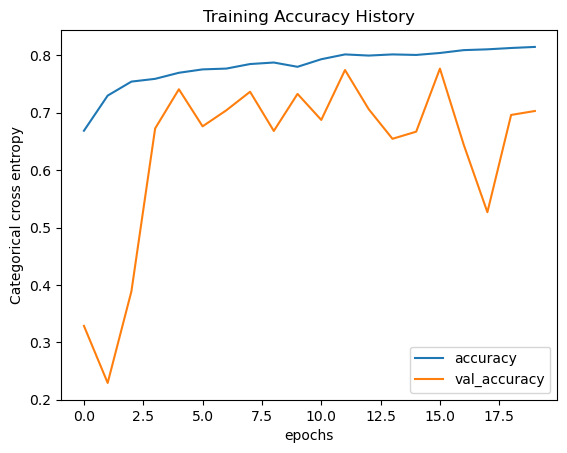

In [17]:
train_history = pd.DataFrame(history01.history)
train_history.index.name = 'epochs'

col_list = ['accuracy', 'val_accuracy']
train_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training Accuracy History')
plt.show()

### CNN -  Spec Arrays

In [112]:
model02 = Sequential()

#layer one
model02.add(Conv2D(filters=32,
                        kernel_size=(5, 5),
                        input_shape=(128, 128, 1)))
model02.add(BatchNormalization())
model02.add(ReLU())
model02.add(MaxPooling2D(pool_size=(2, 2)))

#layer two
model02.add(Conv2D(filters=64,
                        kernel_size=(3, 3)))
model02.add(BatchNormalization())
model02.add(ReLU())
model02.add(MaxPooling2D(pool_size=(2, 2)))

#layer three
#model02.add(Conv2D(filters=64,
                        #kernel_size=(4, 4)))
#model02.add(BatchNormalization())
#model02.add(ReLU())
#model02.add(MaxPooling2D(pool_size=(2, 2)))


# transition to dense fully-connected part of network
model02.add(GlobalAveragePooling2D())

#add dropout layer
#model02.add(Dropout(0.5))
#output layer
model02.add(Dense(5, activation='softmax'))

In [113]:
model02.compile(optimizer=Adam(learning_rate = 0.005), loss='categorical_crossentropy',  metrics=['accuracy'])

In [115]:
history02 = model02.fit(X_train_arr, y_train_arr_onehot, epochs=20, batch_size=32, verbose = 2, 
                        validation_split=.2)

Epoch 1/20
70/70 - 10s - loss: 1.2524 - accuracy: 0.4816 - val_loss: 3.2851 - val_accuracy: 0.2737 - 10s/epoch - 143ms/step
Epoch 2/20
70/70 - 10s - loss: 1.2104 - accuracy: 0.5134 - val_loss: 1.9315 - val_accuracy: 0.2540 - 10s/epoch - 143ms/step
Epoch 3/20
70/70 - 10s - loss: 1.2007 - accuracy: 0.5197 - val_loss: 2.5296 - val_accuracy: 0.1950 - 10s/epoch - 143ms/step
Epoch 4/20
70/70 - 10s - loss: 1.1893 - accuracy: 0.5206 - val_loss: 1.4300 - val_accuracy: 0.3936 - 10s/epoch - 144ms/step
Epoch 5/20
70/70 - 10s - loss: 1.1883 - accuracy: 0.5255 - val_loss: 1.7556 - val_accuracy: 0.3023 - 10s/epoch - 144ms/step
Epoch 6/20
70/70 - 10s - loss: 1.1643 - accuracy: 0.5452 - val_loss: 1.2676 - val_accuracy: 0.4902 - 10s/epoch - 147ms/step
Epoch 7/20
70/70 - 11s - loss: 1.1651 - accuracy: 0.5421 - val_loss: 3.4829 - val_accuracy: 0.2809 - 11s/epoch - 158ms/step
Epoch 8/20
70/70 - 13s - loss: 1.1715 - accuracy: 0.5474 - val_loss: 7.4880 - val_accuracy: 0.2165 - 13s/epoch - 182ms/step
Epoch 9/

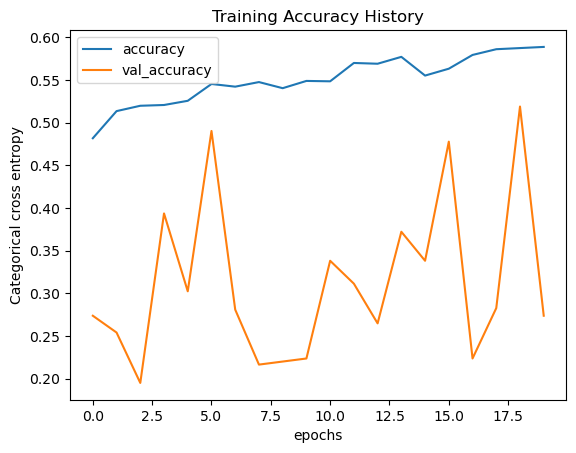

In [116]:
train_history = pd.DataFrame(history02.history)
train_history.index.name = 'epochs'

col_list = ['accuracy', 'val_accuracy']
train_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training Accuracy History')
plt.show()

## Modeling w/ Extracted Features

#### 1. Random Forest

In [73]:
rfc = RandomForestClassifier(random_state=SEED)
rfc_model_pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components = 7)), ('rfc', rfc)])

In [74]:
rfc_model_pipe.fit(X_train_featglobal, y_train_featglobal)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=7)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [75]:
rfc_model_pipe.score(X_train_featglobal, y_train_featglobal)

1.0

In [77]:
params_rfc = {
    'rfc__n_estimators': [100, 200],
    'rfc__min_samples_split': [2, 3, 4],
    'rfc__min_samples_leaf': [3, 4],
    'rfc__max_depth': [3, 7, 10],
    'rfc__criterion': ['gini'],
    'pca__n_components': [2, 5, 8]}

rfc_gs_cv = GridSearchCV(estimator=rfc_model_pipe, param_grid=params_rfc,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
rfc_gs_cv.fit(X_train_featglobal, y_train_featglobal)
end_time = time.time()

print(rfc_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'pca__n_components': 8, 'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 3, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 100}
Time taken: 173.249520778656 seconds


In [78]:
rfc_best_model = rfc_gs_cv.best_estimator_
rfc_best_train_score = rfc_gs_cv.cv_results_['mean_train_score'][rfc_gs_cv.best_index_]
rfc_best_test_score = rfc_gs_cv.best_score_

print('RFC Best Model:', rfc_best_model)
print("RFC Best Model Train Accuracy Score:", rfc_best_train_score)
print("RFC Best Model Test Accuracy Score:", rfc_best_test_score)

RFC Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=8)),
                ('rfc',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        random_state=42))])
RFC Best Model Train Accuracy Score: 0.8108027454491197
RFC Best Model Test Accuracy Score: 0.66771113100567


In [79]:
#Let's try fitting rfc on dataset with fewer features 
#(relevant features are reduced to global average as opposed to per pitch class average)
rfc_model_pipe.fit(X_train_feat, y_train_feat)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=7)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [80]:
rfc_model_pipe.score(X_train_feat, y_train_feat)

0.9997015816174276

In [81]:
params_rfc = {
    'rfc__n_estimators': [10, 50, 100],
    'rfc__min_samples_split': [2, 3, 4],
    'rfc__min_samples_leaf': [3, 4],
    'rfc__max_depth': [3, 7, 10],
    'rfc__criterion': ['gini'],
    'pca__n_components': [10, 25, 50]}

rfc_gs_cv = GridSearchCV(estimator=rfc_model_pipe, param_grid=params_rfc,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
rfc_gs_cv.fit(X_train_feat, y_train_feat)
end_time = time.time()

print(rfc_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
{'pca__n_components': 50, 'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 4, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 100}
Time taken: 236.7281301021576 seconds


In [82]:
rfc_best_model = rfc_gs_cv.best_estimator_
rfc_best_train_score = rfc_gs_cv.cv_results_['mean_train_score'][rfc_gs_cv.best_index_]
rfc_best_test_score = rfc_gs_cv.best_score_

print('RFC Best Model:', rfc_best_model)
print("RFC Best Model Train Accuracy Score:", rfc_best_train_score)
print("RFC Best Model Test Accuracy Score:", rfc_best_test_score)

RFC Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('rfc',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=4,
                                        random_state=42))])
RFC Best Model Train Accuracy Score: 0.9004028648164727
RFC Best Model Test Accuracy Score: 0.7012831990450611


#### 2. Logistic Regression

In [236]:
lgr_model_pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components = 50)), ('model', LogisticRegression(solver='newton-cg', random_state=SEED))])
lgr_model_pipe.fit(X_train_feat, y_train_feat)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('model',
                 LogisticRegression(random_state=42, solver='newton-cg'))])

In [237]:
lgr_model_pipe.score(X_train_feat, y_train_feat)

0.657856093979442

In [155]:
params_lgr = {
    'model__penalty': ['l2', 'l1', None],
    'model__tol': [0.0001, .001],
    'model__C': [.05, .1, 1],
    'model__max_iter': [50, 100],
    'model__solver': ['newton-cg', 'sag', 'saga']}

lgr_gs_cv = GridSearchCV(estimator=lgr_model_pipe, param_grid=params_lgr,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
lgr_gs_cv.fit(X_train_feat, y_train_feat)
end_time = time.time()

print(lgr_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

{'model__C': 0.05, 'model__max_iter': 50, 'model__penalty': 'l2', 'model__solver': 'saga', 'model__tol': 0.0001}
Time taken: 53.92431616783142 seconds


/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [156]:
lgr_best_model = lgr_gs_cv.best_estimator_
lgr_best_train_score = lgr_gs_cv.cv_results_['mean_train_score'][lgr_gs_cv.best_index_]
lgr_best_test_score = lgr_gs_cv.best_score_

print('Log Regression Best Model:', lgr_best_model)
print("Log Regression Best Model Train Accuracy Score:", lgr_best_train_score)
print("Log Regression Best Model Test Accuracy Score:", lgr_best_test_score)

Log Regression Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.05, max_iter=50, random_state=42,
                                    solver='saga'))])
Log Regression Best Model Train Accuracy Score: 0.6508810572687226
Log Regression Best Model Test Accuracy Score: 0.5991189427312775


In [157]:
lgr_model_pipe.fit(X_train_featglobal, y_train_featglobal)
lgr_model_pipe.score(X_train_featglobal, y_train_featglobal)

0.5646108663729809